# Generating clustered state

In [1]:
import numpy as np
from scipy.stats import unitary_group
from opt_einsum import contract
import torch

from src.QDDPM_torch import DiffusionModel, QDDPM, naturalDistance

import time

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('axes', linewidth=3)

/Users/benadmin/Projects/George Research/QuantGenMdl/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Please first ``pip install -U qiskit`` to enable related functionality in translation module


## data set generation

In [10]:
def cluster0Gen(n, N_train, scale, seed=None):
    '''
    generate random quantum states close to |0...0>
    Args:
    n: number of qubits
    N_train: number of data to generate
    scale: the scaling factor on amplitudes except |0...0>
    seed: control the randomness
    '''
    np.random.seed(seed)
    # amplitude for basis except |0...0>
    # Generate two random number dim N_train x (2**n)-1 matrices. The second is multiplied by 1j
    # to become the complex part of the first
    remains = np.random.randn(N_train,2**n-1)+1j*np.random.randn(N_train,2**n-1) 
    
    
    # Creates a N_train x 1 array and appends it to remains to create a N_train x 2**n matrix
    states = np.hstack((np.ones((N_train,1)), scale*remains)) # un-normalized
    print(states.shape)
    print(states[0])
    # Normalizes, transposes
    states /= np.tile(np.linalg.norm(states, axis=1).reshape((1, N_train)), (2**n, 1)).T
    
    #Returns as complex
    return states.astype(np.complex64)

# 1-qubit cluster problem

## Generate diffusion data

In [5]:
# generate dfifusion data set
n = 1
T = 20
Ndata = 1000

diff_hs = np.linspace(1., 4., T)
diff_hs = torch.from_numpy(diff_hs)

model_diff = DiffusionModel(n, T, Ndata)

temp = cluster0Gen(1, Ndata, 0.08, seed=12)
print(temp)

X = torch.from_numpy(temp)

Xout = np.zeros((T+1, Ndata, 2**n), dtype=np.complex64)
Xout[0] = X.numpy()
for t in range(1, T+1):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed=t).numpy()

print()
print(Xout.shape)

[[ 0.98808026+0.j          0.03738784+0.14933048j]
 [ 0.9890759 +0.j         -0.05391856+0.13719186j]
 [ 0.999809  +0.j          0.01939146-0.00242308j]
 ...
 [ 0.9777687 +0.j          0.06711803-0.19865413j]
 [ 0.99549836+0.j          0.07961121+0.05143075j]
 [ 0.9938019 +0.j         -0.09725203-0.05385051j]]

(21, 1000, 2)


visulaize the decay of fidelity

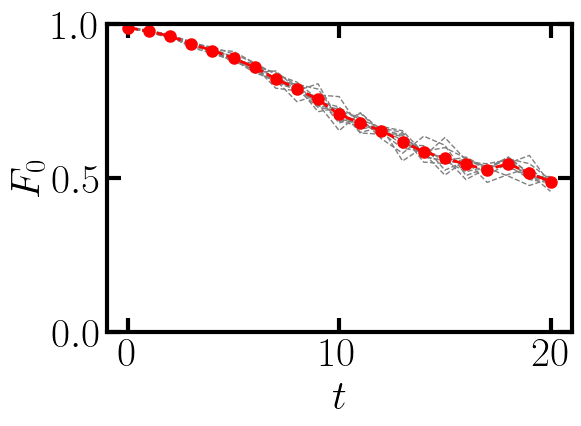

In [4]:
# visualize the fidelity decay in the diffusion process
n = 1
T = 20
N = 1000
states_diff = np.load('data/cluster/n%d/cluster0Diff_n%dT%d_N%d.npy'%(n, n, T, N))
fig, ax = plt.subplots(figsize=(6, 4))
indices = np.random.permutation(1000)
for i in range(10):
    ax.plot(range(T+1), np.mean(np.abs(states_diff[:, indices[100*i:100*(i+1)], 0])**2, axis=1),
            '--', lw=1, c='grey')
ax.plot(range(T+1), np.mean(np.abs(states_diff[:,:,0])**2, axis=1), 'o--', markersize=8, lw=2, c='r')
ax.set_ylabel(r'$F_0$', fontsize=30)
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_ylim(0,1)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

## Training QDDPM

In [5]:
def Training_t(model, t, inputs_T, params_tot, Ndata, epochs):
    '''
    the trianing for the backward PQC at step t
    input_tplus1: the output from step t+1, as the role of input at step t
    Args:
    model: the QDDPM model
    t: the diffusion step
    inputs_T: the input data at step t=T
    params_tot: collection of PQC parameters before step t
    Ndata: number of samples in dataset
    epochs: the number of iterations
    '''
    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history

    # initialize parameters
    np.random.seed()
    params_t = torch.tensor(np.random.normal(size=2 * model.n_tot * model.L), requires_grad=True)
    # set optimizer and learning rate decay
    optimizer = torch.optim.Adam([params_t], lr=0.0005)
    
    t0 = time.time()
    for step in range(epochs):
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]

        output_t = model.backwardOutput_t(input_tplus1, params_t)
        loss = naturalDistance(output_t, true_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_hist.append(loss) # record the current loss
        
        if step%100 == 0:
            loss_value = loss_hist[-1]
            print("Step %s, loss: %s, time elapsed: %s seconds"%(step, loss_value, time.time() - t0))

    return params_t, torch.stack(loss_hist)

In [6]:
# denoise training

n, na = 1, 1 # number of data and ancilla qubits
T = 20 # number of diffusion steps
L = 4 # layer of backward PQC
Ndata = 100 # number of data in the training data set
epochs = 2001 # number of training epochs

# generate random samples at step t=T
diffModel = DiffusionModel(n, T, Ndata)
inputs_T = diffModel.HaarSampleGeneration(Ndata, seed=22)

# load diffusion process
states_diff = np.load('data/cluster/n1/cluster0Diff_n1T20_N1000.npy')
model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)

for t in range(T-1, -1, -1):
    params_tot = np.zeros((T, 2*(n+na)*L))
    for tt in range(t+1, 20):
        params_tot[tt] = np.load('data/cluster/n1/QDDPMcluster0params_n1na1T20L4_t%d_mmd.npy'%tt)
    params, loss_hist = Training_t(model, t, inputs_T, params_tot, Ndata, epochs)
    
    np.save('data/cluster/n1/QDDPMcluster0params_n1na1T20L4_t%d_mmd.npy'%t, params.detach().numpy())
    np.save('data/cluster/n1/QDDPMcluster0losshist_n1na1T20L4_t%d_mmd.npy'%t, loss_hist.detach().numpy())

Step 0, loss: tensor(0.0028, grad_fn=<SubBackward0>), time elapsed: 0.1276388168334961 seconds
Step 100, loss: tensor(0.0130, grad_fn=<SubBackward0>), time elapsed: 1.4643216133117676 seconds
Step 200, loss: tensor(0.0081, grad_fn=<SubBackward0>), time elapsed: 2.7975528240203857 seconds
Step 300, loss: tensor(0.0043, grad_fn=<SubBackward0>), time elapsed: 4.164577960968018 seconds
Step 400, loss: tensor(0.0118, grad_fn=<SubBackward0>), time elapsed: 5.53131103515625 seconds
Step 500, loss: tensor(0.0089, grad_fn=<SubBackward0>), time elapsed: 6.814579725265503 seconds
Step 600, loss: tensor(0.0137, grad_fn=<SubBackward0>), time elapsed: 8.15033221244812 seconds
Step 700, loss: tensor(0.0142, grad_fn=<SubBackward0>), time elapsed: 9.449396848678589 seconds
Step 800, loss: tensor(0.0085, grad_fn=<SubBackward0>), time elapsed: 10.781500101089478 seconds
Step 900, loss: tensor(0.0052, grad_fn=<SubBackward0>), time elapsed: 12.050882339477539 seconds
Step 1000, loss: tensor(0.0035, grad_fn

## Performance test after training

### Generate the training and test data from optimized PQC

In [8]:
# collect trainining result
T = 20
L = 4
epochs = 2001

params_tot = np.zeros((T, 2*(n+na)*L))
loss_tot = np.zeros((T, epochs))

for t in range(T):
    params_tot[t] = np.load('data/cluster/n1/QDDPMcluster0params_n1na1T%dL4_t%d_mmd.npy'%(T, t))
    loss_tot[t] = np.load('data/cluster/n1/QDDPMcluster0losshist_n1na1T%dL4_t%d_mmd.npy'%(T, t))
                            
np.save('data/cluster/n1/QDDPMcluster0params_n1na1T%dL4_mmd.npy'%T, params_tot)
np.save('data/cluster/n1/QDDPMcluster0loss_n1na1T%dL4_mmd.npy'%T, loss_tot)

In [10]:
# generate training & test data
n, na = 1, 1
T = 20
L = 4
Ndata = 100

diffModel = DiffusionModel(n, T, Ndata)
inputs_T_tr = diffModel.HaarSampleGeneration(Ndata, seed=22) # same data as used in training
inputs_T_te = diffModel.HaarSampleGeneration(Ndata, seed=28) # another independent data of Haar states

params_tot = np.load('data/cluster/n1/QDDPMcluster0params_n1na1T%dL4_mmd.npy'%T)

model = QDDPM(n=n, na=na, T=T, L=L)

data_tr = model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n]
data_te = model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n]

np.save('data/cluster/n1/QDDPMcluster0trainGen_n1na1T%dL4_mmd.npy'%T, data_tr.numpy())
np.save('data/cluster/n1/QDDPMcluster0testGen_n1na1T%dL4_mmd.npy'%T, data_te.numpy())

### Visulize the performance in fidelity

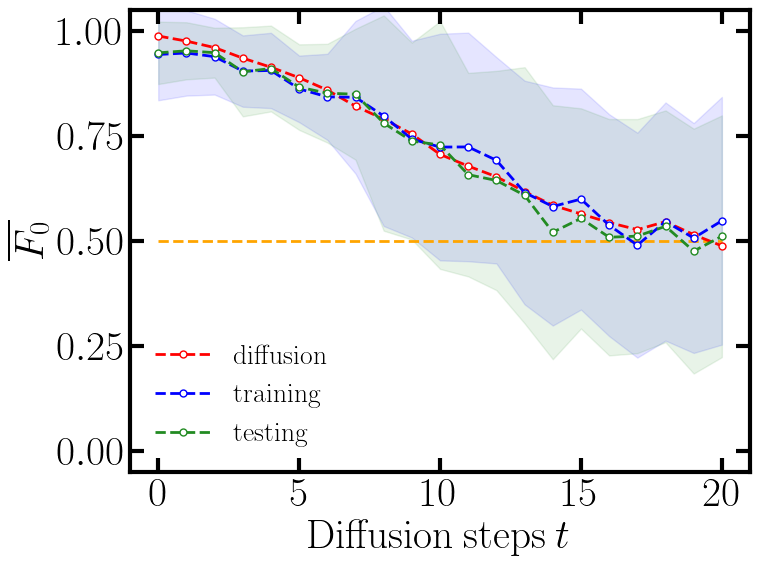

In [12]:
# plot the performance of training
n, na = 1, 1
T = 20
L = 4
Ndata = 100
states_diff = np.load('data/cluster/n1/cluster0Diff_n1T20_N1000.npy')
states_train = np.load('data/cluster/n1/QDDPMcluster0trainGen_n1na1T20L4_mmd.npy')
states_test = np.load('data/cluster/n1/QDDPMcluster0testGen_n1na1T20L4_mmd.npy')

F0_train = np.abs(states_train[:, :, 0])**2
F0_test = np.abs(states_test[:, :, 0])**2
F0_diff = np.abs(states_diff[:, :, 0])**2

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(T+1), np.mean(F0_diff, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='r', 
            zorder=5, label=r'$\rm diffusion$')
ax.plot(range(T+1), 0.5*np.ones(T+1), '--', lw=2, c='orange')

ax.plot(range(T+1), np.mean(F0_train, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='b', 
            zorder=5, label=r'$\rm training$')
ax.fill_between(range(T+1), np.mean(F0_train, axis=1)-np.std(F0_train, axis=1), 
                    np.mean(F0_train, axis=1)+np.std(F0_train, axis=1), color='b', alpha=0.1)

ax.plot(range(T+1), np.mean(F0_test, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', 
            zorder=5, label=r'$\rm testing$')
ax.fill_between(range(T+1), np.mean(F0_test, axis=1)-np.std(F0_test, axis=1), 
                    np.mean(F0_test, axis=1)+np.std(F0_test, axis=1), color='forestgreen', alpha=0.1)

ax.legend(fontsize=20, framealpha=0)
ax.set_ylim(-0.05, 1.05)
ax.set_xticks(np.arange(0, T+1, 5))
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$\overline{F_0}$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

plt.show()
plt.close()

### Visulize the performance in MMD

In [12]:
# calculate MMD
X = torch.from_numpy(np.load('data/cluster/n1/cluster0Diff_n1T20_N1000.npy'))
X_train = torch.from_numpy(np.load('data/cluster/n1/QDDPMcluster0trainGen_n1na1T20L4_mmd.npy'))
X_test = torch.from_numpy(np.load('data/cluster/n1/QDDPMcluster0testGen_n1na1T20L4_mmd.npy'))
X0 = torch.from_numpy(cluster0Gen(1, 1000, 0.08, seed=16))

mmds = np.zeros((3, 21))
for t in range(21):
    idx = np.random.choice(X.shape[1], size=100, replace=False)
    mmds[0, t] = naturalDistance(X0, X[t, idx])
    mmds[1, t] = naturalDistance(X0, X_train[t])
    mmds[2, t] = naturalDistance(X0, X_test[t])
np.save('data/cluster/n1/QDDPMcluster0Genloss_n1na1T20L4_mmd.npy', mmds)

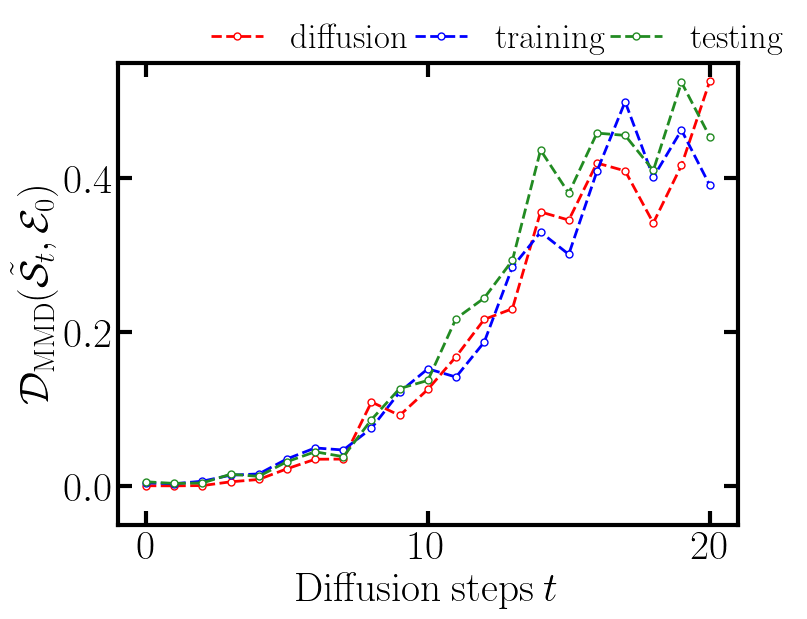

In [13]:
mmds = np.load('data/cluster/n1/QDDPMcluster0Genloss_n1na1T20L4_mmd.npy')

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(mmds[0], 'o--', markersize=5, mfc='white', lw=2, c='r', label=r'$\rm diffusion$')
ax.plot(mmds[1], 'o--', markersize=5, mfc='white', lw=2, c='b', label=r'$\rm training$')
ax.plot(mmds[2], 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', label=r'$\rm testing$')

ax.legend(loc='lower left', bbox_to_anchor=(0.1, 0.95), fontsize=25, framealpha=0, labelspacing=0.4,
          ncol=3, columnspacing=0.2, handlelength=1.5)
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$\mathcal{D}_{\rm MMD}(\tilde{\mathcal{S}}_t, \mathcal{E}_0)$', fontsize=30)
ax.set_ylim(-0.05, 0.55)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

### Plot the training history

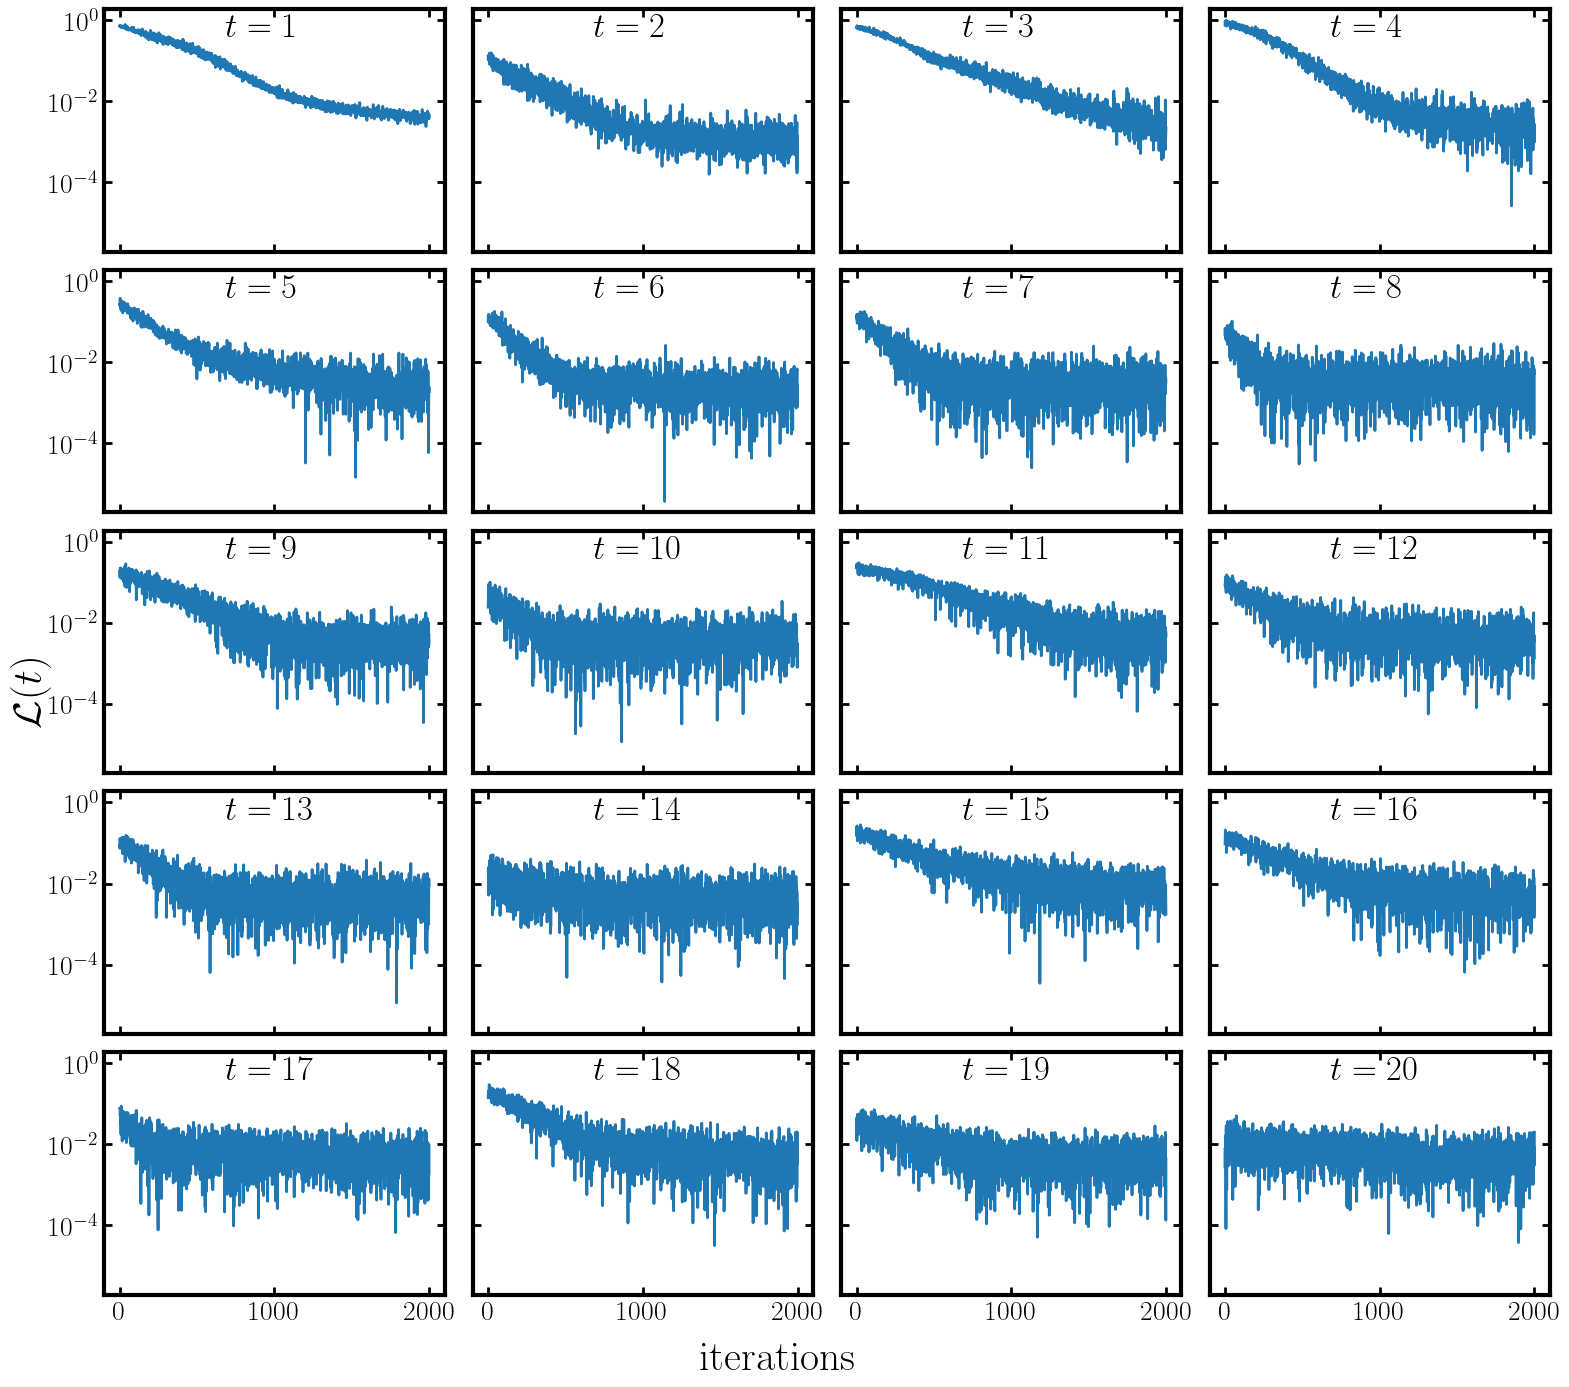

In [14]:
# plot training loss history
n, na = 1, 1
T = 20
L = 4
loss = np.load('data/cluster/n1/QDDPMcluster0loss_n1na1T20L4_mmd.npy')
fig, axs = plt.subplots(5, 4, figsize=(16, 14), sharex=True, sharey=True)
for i in range(20):
    axs[i//4, i%4].plot(loss[i], lw=2)
    axs[i//4, i%4].tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=20)
    axs[i//4, i%4].text(x=680, y=0.4, s=r'$t=%d$'%(i+1), fontsize=25)
    axs[i//4, i%4].set_yscale('log')
fig.supxlabel(r'$\rm iterations$', fontsize=30)
fig.supylabel(r'$\mathcal{L}(t)$', fontsize=30)
plt.tight_layout()
plt.show()
plt.close()

# 2-qubit cluster problem

## generate diffusion data

In [12]:
# generate diffusion data set
n = 2
T = 20
Ndata = 1000

diff_hs = np.linspace(0.5, 4., T)

model_diff = DiffusionModel(n, T, Ndata)
X = torch.from_numpy(cluster0Gen(2, Ndata, 0.06, seed=12))
print(X.shape)
for i in X:
    print(i)
Xout = np.zeros((T+1, Ndata, 2**n), dtype=np.complex64)
Xout[0] = X
for t in range(1, T+1):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed=t).numpy()
np.save('data/cluster/n2/cluster0Diff_n2T20_N%d.npy'%N, Xout)

(1000, 4)
[ 1.        +0.j          0.02837915-0.02654731j -0.04088555+0.05650218j
  0.01454637-0.11493476j]
torch.Size([1000, 4])
tensor([ 0.9902+0.0000j,  0.0281-0.0263j, -0.0405+0.0560j,  0.0144-0.1138j])
tensor([ 0.9770+0.0000j, -0.0997-0.0099j,  0.0442+0.1584j, -0.0900-0.0143j])
tensor([ 9.9167e-01+0.0000j,  3.0506e-04+0.0072j, -7.1536e-03+0.0470j,
        -4.8016e-02+0.1094j])
tensor([ 0.9768+0.0000j,  0.1683-0.1062j, -0.0350-0.0587j,  0.0277-0.0273j])
tensor([ 0.9886+0.0000j,  0.0650-0.0337j, -0.0721-0.0228j,  0.0796+0.0718j])
tensor([ 0.9929+0.0000j, -0.0073-0.0700j,  0.0603-0.0511j, -0.0544-0.0033j])
tensor([ 0.9903+0.0000j, -0.0612-0.0341j,  0.0719-0.0448j,  0.0298-0.0792j])
tensor([0.9963+0.0000j, 0.0083-0.0026j, 0.0383+0.0531j, 0.0315-0.0451j])
tensor([ 0.9802+0.0000j, -0.0679-0.0211j, -0.1302-0.0540j, -0.0989-0.0678j])
tensor([ 0.9825+0.0000j, -0.1054-0.0318j, -0.1308+0.0391j, -0.0382-0.0495j])
tensor([ 0.9923+0.0000j, -0.0315-0.0714j, -0.0023+0.0915j,  0.0128-0.0273j])
te

KeyboardInterrupt: 

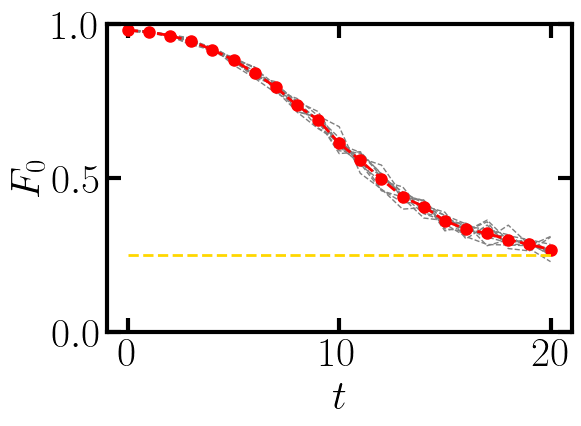

In [16]:
# visualize the fidelity decay in the diffusion process
n = 2
T = 20
Ndata = 1000
states_diff = np.load('data/cluster/n2/cluster0Diff_n2T20_N1000.npy')

fig, ax = plt.subplots(figsize=(6, 4))
indices = np.random.permutation(1000)
for i in range(10):
    ax.plot(range(T+1), np.mean(np.abs(states_diff[:, indices[100*i:100*(i+1)], 0])**2, axis=1),
            '--', lw=1, c='grey')
ax.plot(range(T+1), np.mean(np.abs(states_diff[:,:,0])**2, axis=1), 'o--', markersize=8, lw=2, c='r')
ax.plot(range(T+1), 0.25*np.ones(T+1), '--', lw=2, c='gold')
ax.set_ylabel(r'$F_0$', fontsize=30)
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_ylim(0,1)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

## Training

In [19]:
# Training
n, na = 2, 1 # number of data and ancilla qubits
T = 20 # number of diffusion steps
L = 6 # layer of backward PQC
Ndata = 100 # number of data in the training data set
epochs = 2001 # number of training epochs

# generate random samples at step t=T
diffModel = DiffusionModel(n, T, Ndata)
inputs_T = diffModel.HaarSampleGeneration(Ndata, seed=22)

# load diffusion process
states_diff = np.load('data/cluster/n2/cluster0Diff_n2T20_N1000.npy')

model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)

for t in range(T-1, -1, -1):
    params_tot = np.zeros((T, 2*(n+na)*L))
    for tt in range(t+1, 20):
        params_tot[tt] = np.load('data/cluster/n2/QDDPMcluster0params_n2na1T20L6_t%d_mmd.npy'%tt)
    params, loss_hist = Training_t(model, t, inputs_T, params_tot, Ndata, epochs)

    np.save('data/cluster/n2/QDDPMcluster0params_n2na1T20L6_t%d_mmd.npy'%t, params.detach().numpy())
    np.save('data/cluster/n2/QDDPMcluster0loss_n2na1T20L6_t%d_mmd.npy'%t, loss_hist.detach().numpy())

Step 0, loss: tensor(0.0328, grad_fn=<SubBackward0>), time elapsed: 0.03600621223449707 seconds
Step 100, loss: tensor(0.0169, grad_fn=<SubBackward0>), time elapsed: 2.7503621578216553 seconds
Step 200, loss: tensor(0.0238, grad_fn=<SubBackward0>), time elapsed: 5.433981657028198 seconds
Step 300, loss: tensor(0.0231, grad_fn=<SubBackward0>), time elapsed: 8.06718635559082 seconds
Step 400, loss: tensor(0.0076, grad_fn=<SubBackward0>), time elapsed: 10.684119939804077 seconds
Step 500, loss: tensor(0.0049, grad_fn=<SubBackward0>), time elapsed: 13.667561769485474 seconds
Step 600, loss: tensor(0.0033, grad_fn=<SubBackward0>), time elapsed: 16.31776762008667 seconds
Step 700, loss: tensor(0.0076, grad_fn=<SubBackward0>), time elapsed: 18.97156596183777 seconds
Step 800, loss: tensor(0.0121, grad_fn=<SubBackward0>), time elapsed: 21.614961624145508 seconds
Step 900, loss: tensor(0.0088, grad_fn=<SubBackward0>), time elapsed: 24.334514141082764 seconds
Step 1000, loss: tensor(0.0125, grad

## Performance

### Generate training and testing data

In [22]:
# collect trainining result
n, na = 2, 1
T = 20
L = 6
Ndata = 100
epochs = 2001

params_tot = np.zeros((T, 2*(n+na)*L))
loss_tot = np.zeros((T, epochs))
f0_tot = np.zeros((T, epochs))

for t in range(T):
    params_tot[t] = np.load('data/cluster/n2/QDDPMcluster0params_n2na1T20L6_t%d_mmd.npy'%t)
    loss_tot[t] = np.load('data/cluster/n2/QDDPMcluster0loss_n2na1T20L6_t%d_mmd.npy'%t)
    
np.save('data/cluster/n2/QDDPMcluster0params_n2na1T20L6_mmd.npy', params_tot)
np.save('data/cluster/n2/QDDPMcluster0loss_n2na1T20L6_mmd.npy', loss_tot)

In [1]:
# generate training & test data
n, na = 2, 1
T = 20
L = 6
Ndata = 100

params_tot = np.load('data/cluster/n2/QDDPMcluster0params_n2na1T20L6_mmd.npy')

diffModel = DiffusionModel(n, T, Ndata)
inputs_T_tr = diffModel.HaarSampleGeneration(Ndata, seed=22)
inputs_T_te = diffModel.HaarSampleGeneration(Ndata, seed=23)


model = QDDPM(n=n, na=na, T=T, L=L)

data_tr = model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n].numpy()
data_te = model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n].numpy()

np.save('data/cluster/n2/QDDPMcluster0trainGen_n2na1T20L6_mmd.npy', data_tr)
np.save('data/cluster/n2/QDDPMcluster0testGen_n2na1T20L6_mmd.npy', data_te)

NameError: name 'np' is not defined

### Visualize in fidelity

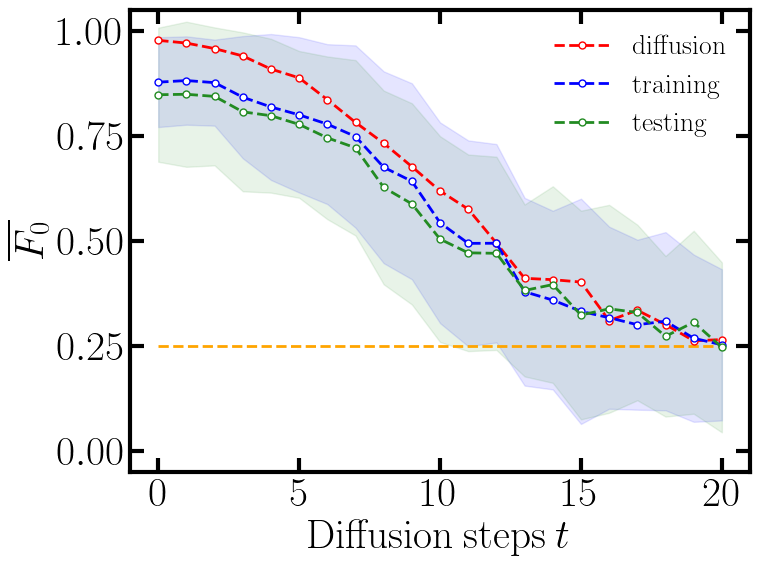

In [32]:
# plot the performance of training
n, na = 2, 1
T = 20
L = 6
Ndata = 100
states_diff = np.load('data/cluster/n2/cluster0Diff_n2T20_N1000.npy')
states_train = np.load('data/cluster/n2/QDDPMcluster0trainGen_n2na1T20L6_mmd.npy')
states_test = np.load('data/cluster/n2/QDDPMcluster0testGen_n2na1T20L6_mmd.npy')

F0_train = np.abs(states_train[:, :, 0])**2
F0_test = np.abs(states_test[:, :, 0])**2
F0_diff = np.abs(states_diff[:, :Ndata, 0])**2

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(T+1), np.mean(F0_diff, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='r', 
            zorder=5, label=r'$\rm diffusion$')
ax.plot(range(T+1), 0.25*np.ones(T+1), '--', lw=2, c='orange')

ax.plot(range(T+1), np.mean(F0_train, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='b', 
            zorder=5, label=r'$\rm training$')
ax.fill_between(range(T+1), np.mean(F0_train, axis=1)-np.std(F0_train, axis=1), 
                    np.mean(F0_train, axis=1)+np.std(F0_train, axis=1), color='b', alpha=0.1)

ax.plot(range(T+1), np.mean(F0_test, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', 
            zorder=5, label=r'$\rm testing$')
ax.fill_between(range(T+1), np.mean(F0_test, axis=1)-np.std(F0_test, axis=1), 
                    np.mean(F0_test, axis=1)+np.std(F0_test, axis=1), color='forestgreen', alpha=0.1)

ax.legend(fontsize=20, framealpha=0)
ax.set_ylim(-0.05, 1.05)
ax.set_xticks(np.arange(0, T+1, 5))
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$\overline{F_0}$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

### visualize in MMD

In [33]:
# calculate MMD
X = torch.from_numpy(np.load('data/cluster/n2/cluster0Diff_n2T20_N1000.npy'))
X_train = torch.from_numpy(np.load('data/cluster/n2/QDDPMcluster0trainGen_n2na1T20L6_mmd.npy'))
X_test = torch.from_numpy(np.load('data/cluster/n2/QDDPMcluster0testGen_n2na1T20L6_mmd.npy'))
X0 = torch.from_numpy(cluster0Gen(2, 1000, 0.06, seed=16))

mmds = np.zeros((3, 21))
for t in range(21):
    idx = np.random.choice(X.shape[1], size=100, replace=False)
    mmds[0, t] = naturalDistance(X0, X[t, idx])
    mmds[1, t] = naturalDistance(X0, X_train[t])
    mmds[2, t] = naturalDistance(X0, X_test[t])
np.save('data/cluster/n2/QDDPMcluster0Genloss_n2na1T20L6_mmd.npy', mmds)

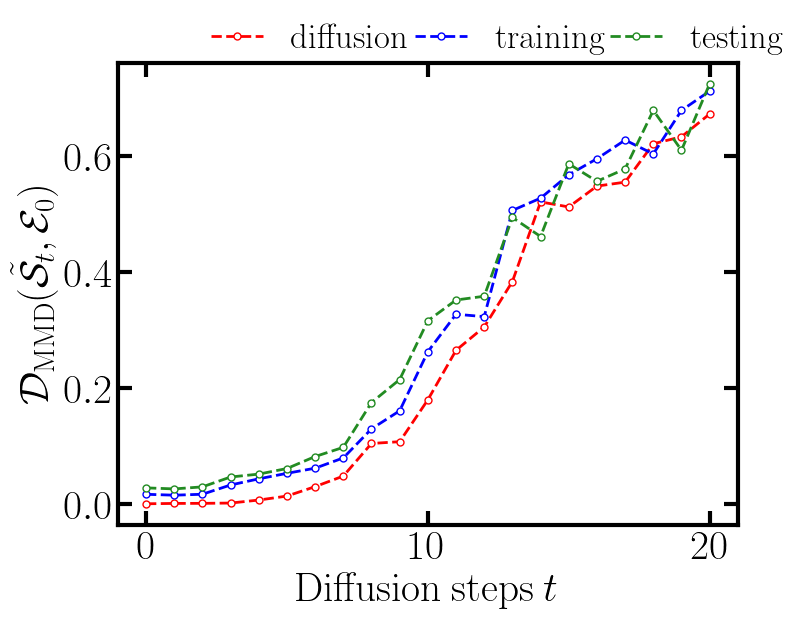

In [34]:
mmds = np.load('data/cluster/n2/QDDPMcluster0Genloss_n2na1T20L6_mmd.npy')

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(mmds[0], 'o--', markersize=5, mfc='white', lw=2, c='r', label=r'$\rm diffusion$')
ax.plot(mmds[1], 'o--', markersize=5, mfc='white', lw=2, c='b', label=r'$\rm training$')
ax.plot(mmds[2], 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', label=r'$\rm testing$')

ax.legend(loc='lower left', bbox_to_anchor=(0.1, 0.95), fontsize=25, framealpha=0, labelspacing=0.4,
          ncol=3, columnspacing=0.2, handlelength=1.5)
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$\mathcal{D}_{\rm MMD}(\tilde{\mathcal{S}}_t, \mathcal{E}_0)$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

### Plot training history

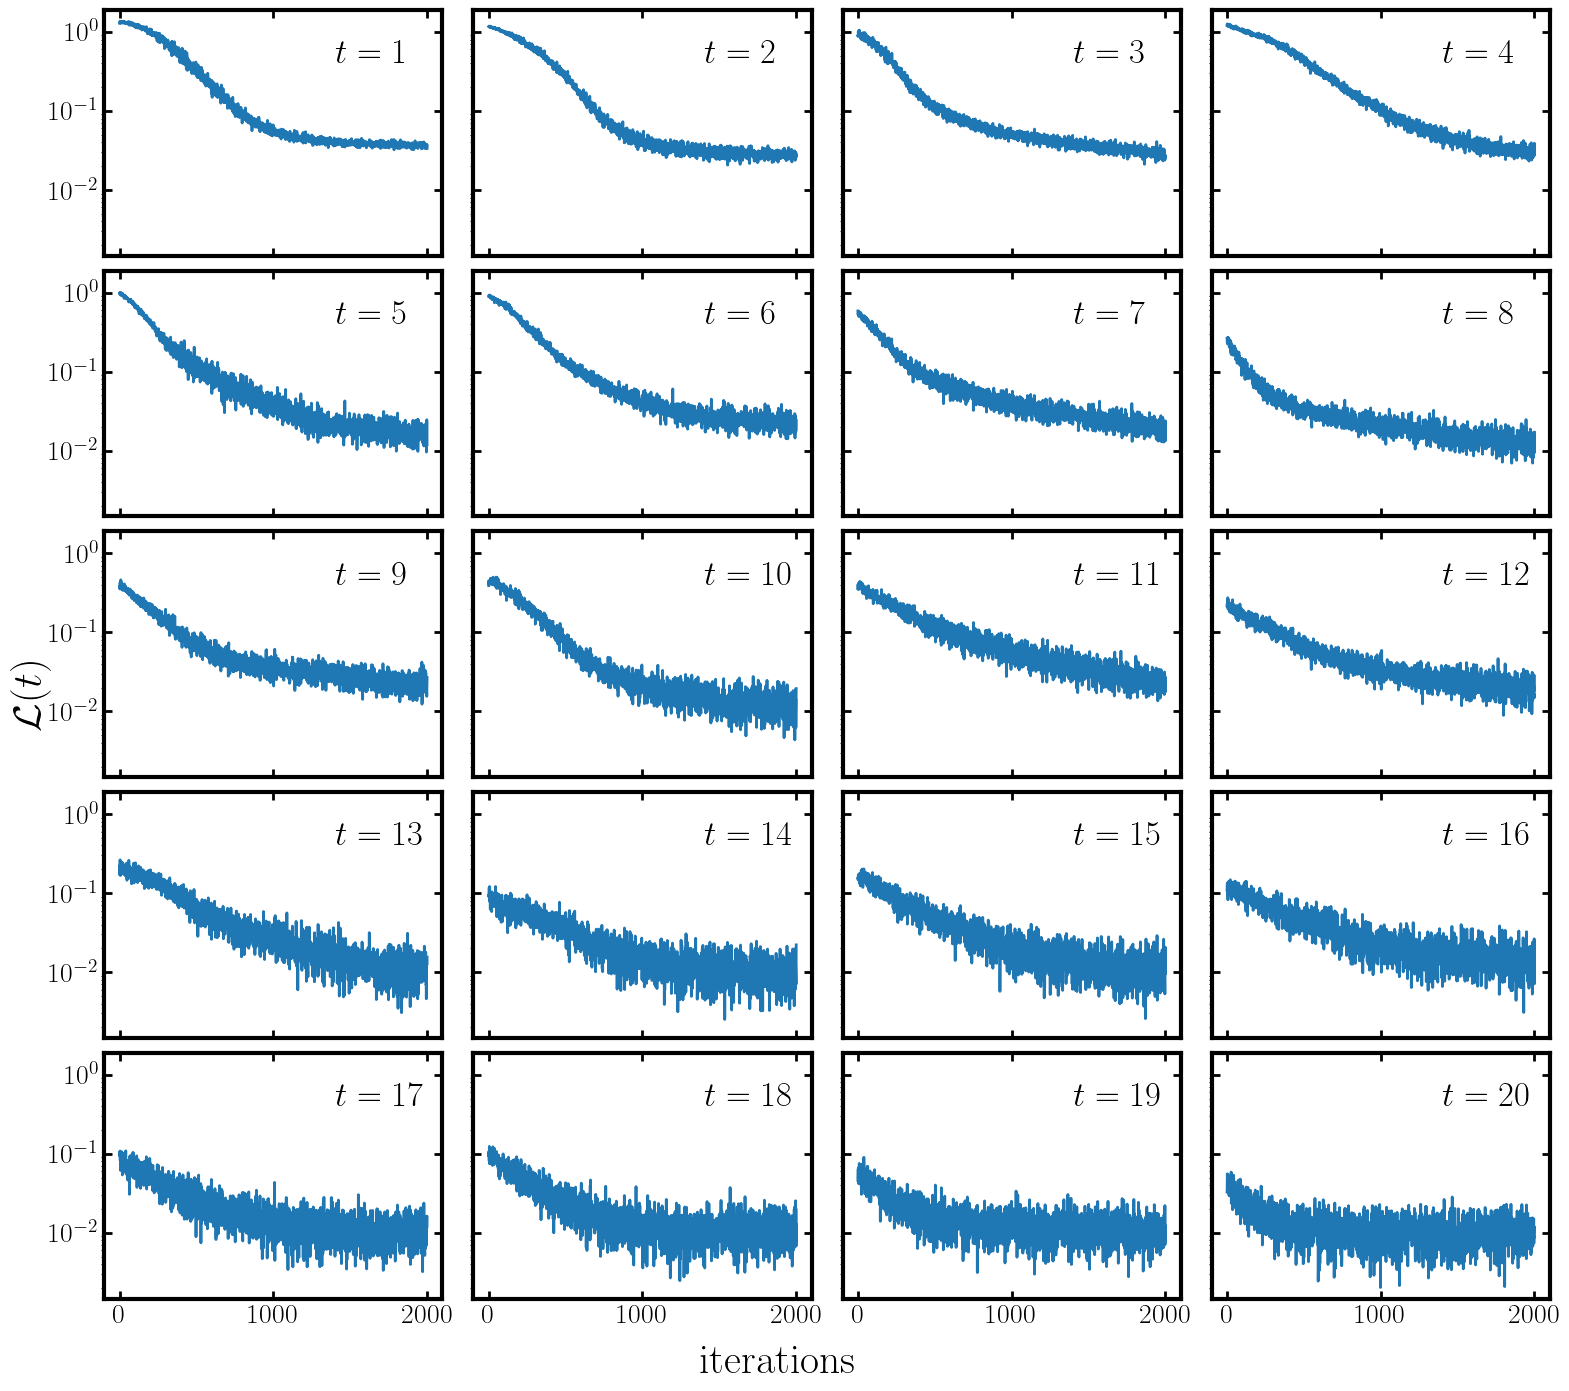

In [35]:
# plot training loss history
n, na = 2, 1
T = 20
L = 6
loss = np.load('data/cluster/n2/QDDPMcluster0loss_n2na1T20L6_mmd.npy')
fig, axs = plt.subplots(5, 4, figsize=(16, 14), sharex=True, sharey=True)
for i in range(20):
    axs[i//4, i%4].plot(loss[i], lw=2)
    axs[i//4, i%4].tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=20)
    axs[i//4, i%4].text(x=1400, y=0.4, s=r'$t=%d$'%(i+1), fontsize=25)
    axs[i//4, i%4].set_yscale('log')
fig.supxlabel(r'$\rm iterations$', fontsize=30)
fig.supylabel(r'$\mathcal{L}(t)$', fontsize=30)
plt.tight_layout()

In [36]:
np.mean(F0_diff[:, 0], axis=1), np.std(F0_diff[:, 0], axis=1),\
np.mean(F0_train[:, 0], axis=1), np.std(F0_train[:, 0], axis=1),\
np.mean(F0_test[:, 0], axis=1), np.std(F0_test[:, 0], axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1